Epoch 1/50


2024-11-02 13:39:35.848194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 2s 19ms/step - loss: 1.3289
Epoch 2/50
57/57 [==============================] - 1s 22ms/step - loss: 0.9188
Epoch 3/50
57/57 [==============================] - 1s 21ms/step - loss: 0.8512
Epoch 4/50
57/57 [==============================] - 1s 21ms/step - loss: 0.8459
Epoch 5/50
57/57 [==============================] - 1s 21ms/step - loss: 0.8326
Epoch 6/50
57/57 [==============================] - 1s 21ms/step - loss: 0.8242
Epoch 7/50
57/57 [==============================] - 1s 22ms/step - loss: 0.8202
Epoch 8/50
57/57 [==============================] - 1s 21ms/step - loss: 0.8066
Epoch 9/50
57/57 [==============================] - 1s 23ms/step - loss: 0.8177
Epoch 10/50
57/57 [==============================] - 1s 22ms/step - loss: 0.8007
Epoch 11/50
57/57 [==============================] - 1s 21ms/step - loss: 0.7892
Epoch 12/50
57/57 [==============================] - 1s 23ms/step - loss: 0.8087
Epoch 13/50
57/57 [=============================

/var/folders/j3/kwprsg3s3_zf9_90gxwcknm00000gn/T/ipykernel_13620/3931869585.py:79: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_dates = pd.date_range(start=data['DATETIME'].max() + pd.Timedelta(hours=8), periods=n_future, freq='8H')


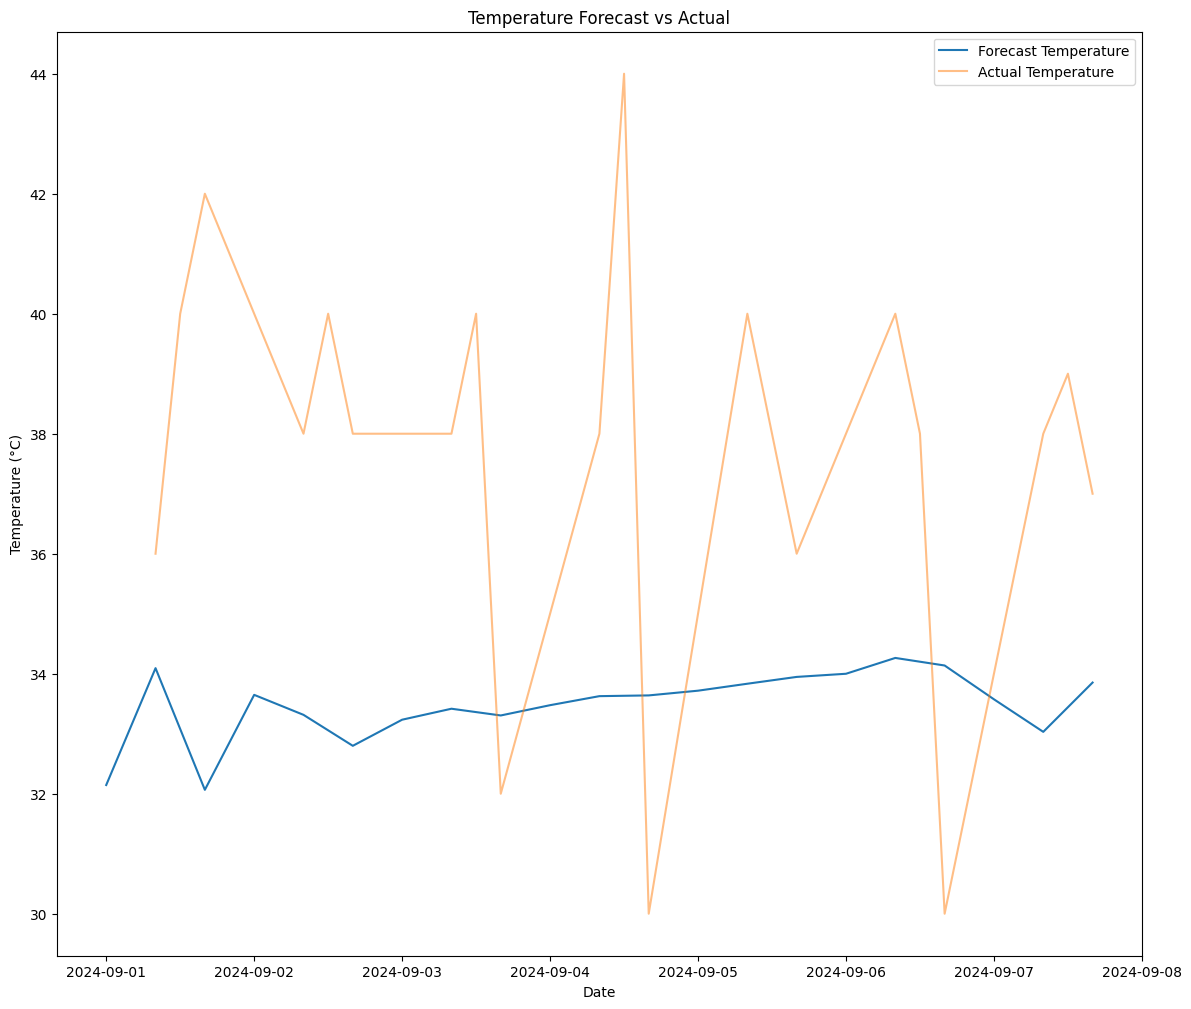

    TEMPERATURE (°C)  RAINFALL (mm)            DATETIME  ACTUAL CONDITION  \
0          32.144943       0.812180 2024-09-01 00:00:00                 3   
1          34.092873       0.597596 2024-09-01 08:00:00                 4   
2          32.064800       1.091357 2024-09-01 16:00:00                 3   
3          33.647770       1.046218 2024-09-02 00:00:00                 4   
4          33.314819       1.065090 2024-09-02 08:00:00                 4   
5          32.798561       1.191692 2024-09-02 16:00:00                 4   
6          33.233654       1.180702 2024-09-03 00:00:00                 4   
7          33.416580       1.164250 2024-09-03 08:00:00                 4   
8          33.304276       1.182922 2024-09-03 16:00:00                 4   
9          33.475624       1.185029 2024-09-04 00:00:00                 4   
10         33.626217       1.169696 2024-09-04 08:00:00                 4   
11         33.638577       1.166388 2024-09-04 16:00:00                 4   

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

# Load dataset
data = pd.read_csv('Cleaned_MCS_TEAM_DATAX.csv')

# Convert 'DATETIME' to datetime object
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

# Sort dataset by date
data = data.sort_values(by='DATETIME')

# Identify numerical and categorical features
numerical_features = ['TEMPERATURE (°C)', 'RAINFALL (mm)']
categorical_features = ['ACTUAL CONDITION', 'OCCURENCE OF FLOOD']

# Convert categorical columns to category dtype
data[categorical_features] = data[categorical_features].astype('category')

# Handle categorical data: Encode categorical features
le_condition = LabelEncoder()
le_flood = LabelEncoder()
data['ACTUAL CONDITION'] = le_condition.fit_transform(data['ACTUAL CONDITION'])
data['OCCURENCE OF FLOOD'] = le_flood.fit_transform(data['OCCURENCE OF FLOOD'])

# Scale numerical features to the range [0, 1]
scaler = MinMaxScaler()
scaled_numerical_data = scaler.fit_transform(data[numerical_features])

# Combine scaled numerical data with encoded categorical data
scaled_data = np.hstack((scaled_numerical_data, data[categorical_features].values))

# Prepare time series data
look_back = 21  # Number of time steps to look back (7 days * 3 readings/day)

# Create TimeseriesGenerator for training data
generator = TimeseriesGenerator(scaled_data, scaled_data, length=look_back, batch_size=32)

# Define the GRU Model
model = Sequential()
model.add(GRU(200, activation='relu', input_shape=(look_back, len(numerical_features) + len(categorical_features)), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(numerical_features) + len(categorical_features)))  # Output layer with multiple features

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(generator, epochs=50)

# Forecast the next 7 days (7 * 3 = 21 predictions)
n_future = 21  # Predicting 21 steps ahead (7 days of 3 readings per day)
last_data = scaled_data[-look_back:]  # Take the last 'look_back' period to predict

# Generate predictions for the next 7 days
forecast = []
input_seq = last_data.reshape((1, look_back, len(numerical_features) + len(categorical_features)))

for _ in range(n_future):
    prediction = model.predict(input_seq)
    forecast.append(prediction[0])
    # Update the input sequence with the new prediction
    input_seq = np.append(input_seq[:, 1:, :], [[prediction[0]]], axis=1)

# Convert forecast to a NumPy array
forecast = np.array(forecast)

# Convert forecast back to original scale for numerical features
forecast_numerical = scaler.inverse_transform(forecast[:, :len(numerical_features)])  # Only inverse scale numerical features

# Create a DataFrame for the forecasted data
forecast_dates = pd.date_range(start=data['DATETIME'].max() + pd.Timedelta(hours=8), periods=n_future, freq='8H')
forecast_df = pd.DataFrame(forecast_numerical, columns=numerical_features)
forecast_df['DATETIME'] = forecast_dates

# Add the predicted categorical values to the forecast DataFrame
# Assuming the last two columns of the prediction correspond to the categorical features
forecast_df['ACTUAL CONDITION'] = le_condition.inverse_transform(np.round(forecast[:, len(numerical_features)]).astype(int))
forecast_df['OCCURENCE OF FLOOD'] = le_flood.inverse_transform(np.round(forecast[:, len(numerical_features) + 1]).astype(int))

# Load actual data for comparison
actual_data = pd.read_csv('Actual.csv')
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])

# Plotting the actual vs forecasted data
plt.figure(figsize=(14, 12))
plt.plot(forecast_df['DATETIME'], forecast_df['TEMPERATURE (°C)'], label='Forecast Temperature')
plt.plot(actual_data['DATETIME'], actual_data['TEMPERATURE (°C)'], label='Actual Temperature', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Forecast vs Actual')
plt.show()

# Print the forecasted DataFrame
print(forecast_df)



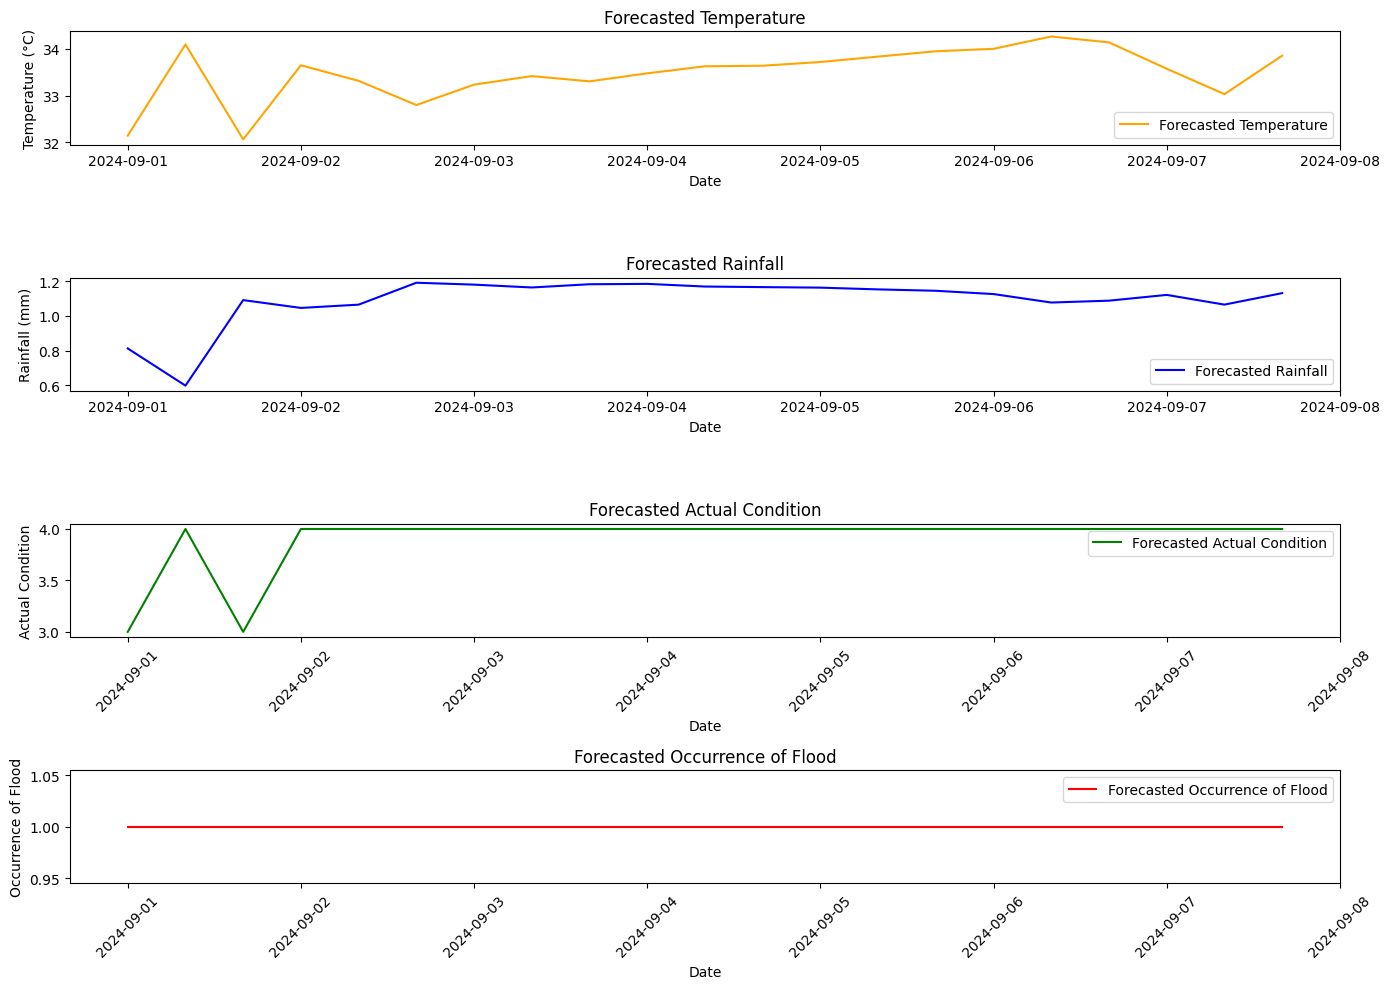

In [11]:
# Visualization of the results (optional)
plt.figure(figsize=(14, 10))

# Plot for Temperature
plt.subplot(4, 1, 1)
plt.plot(forecast_df['DATETIME'], forecast_df['TEMPERATURE (°C)'], label='Forecasted Temperature', color='orange')
plt.title('Forecasted Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot for Rainfall
plt.subplot(4, 1, 2)
plt.plot(forecast_df['DATETIME'], forecast_df['RAINFALL (mm)'], label='Forecasted Rainfall', color='blue')
plt.title('Forecasted Rainfall')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()

# Plot for Actual Condition
plt.subplot(4, 1, 3)
plt.plot(forecast_df['DATETIME'], forecast_df['ACTUAL CONDITION'], label='Forecasted Actual Condition', color='green')
plt.title('Forecasted Actual Condition')
plt.xlabel('Date')
plt.ylabel('Actual Condition')
plt.xticks(rotation=45)
plt.legend()

# Plot for Occurrence of Flood
plt.subplot(4, 1, 4)
plt.plot(forecast_df['DATETIME'], forecast_df['OCCURENCE OF FLOOD'], label='Forecasted Occurrence of Flood', color='red')
plt.title('Forecasted Occurrence of Flood')
plt.xlabel('Date')
plt.ylabel('Occurrence of Flood')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

    TEMPERATURE (°C)  RAINFALL (mm)            DATETIME  ACTUAL CONDITION  \
0          32.144943       0.812180 2024-09-01 00:00:00                 3   
1          34.092873       0.597596 2024-09-01 08:00:00                 4   
2          32.064800       1.091357 2024-09-01 16:00:00                 3   
3          33.647770       1.046218 2024-09-02 00:00:00                 4   
4          33.314819       1.065090 2024-09-02 08:00:00                 4   
5          32.798561       1.191692 2024-09-02 16:00:00                 4   
6          33.233654       1.180702 2024-09-03 00:00:00                 4   
7          33.416580       1.164250 2024-09-03 08:00:00                 4   
8          33.304276       1.182922 2024-09-03 16:00:00                 4   
9          33.475624       1.185029 2024-09-04 00:00:00                 4   
10         33.626217       1.169696 2024-09-04 08:00:00                 4   
11         33.638577       1.166388 2024-09-04 16:00:00                 4   

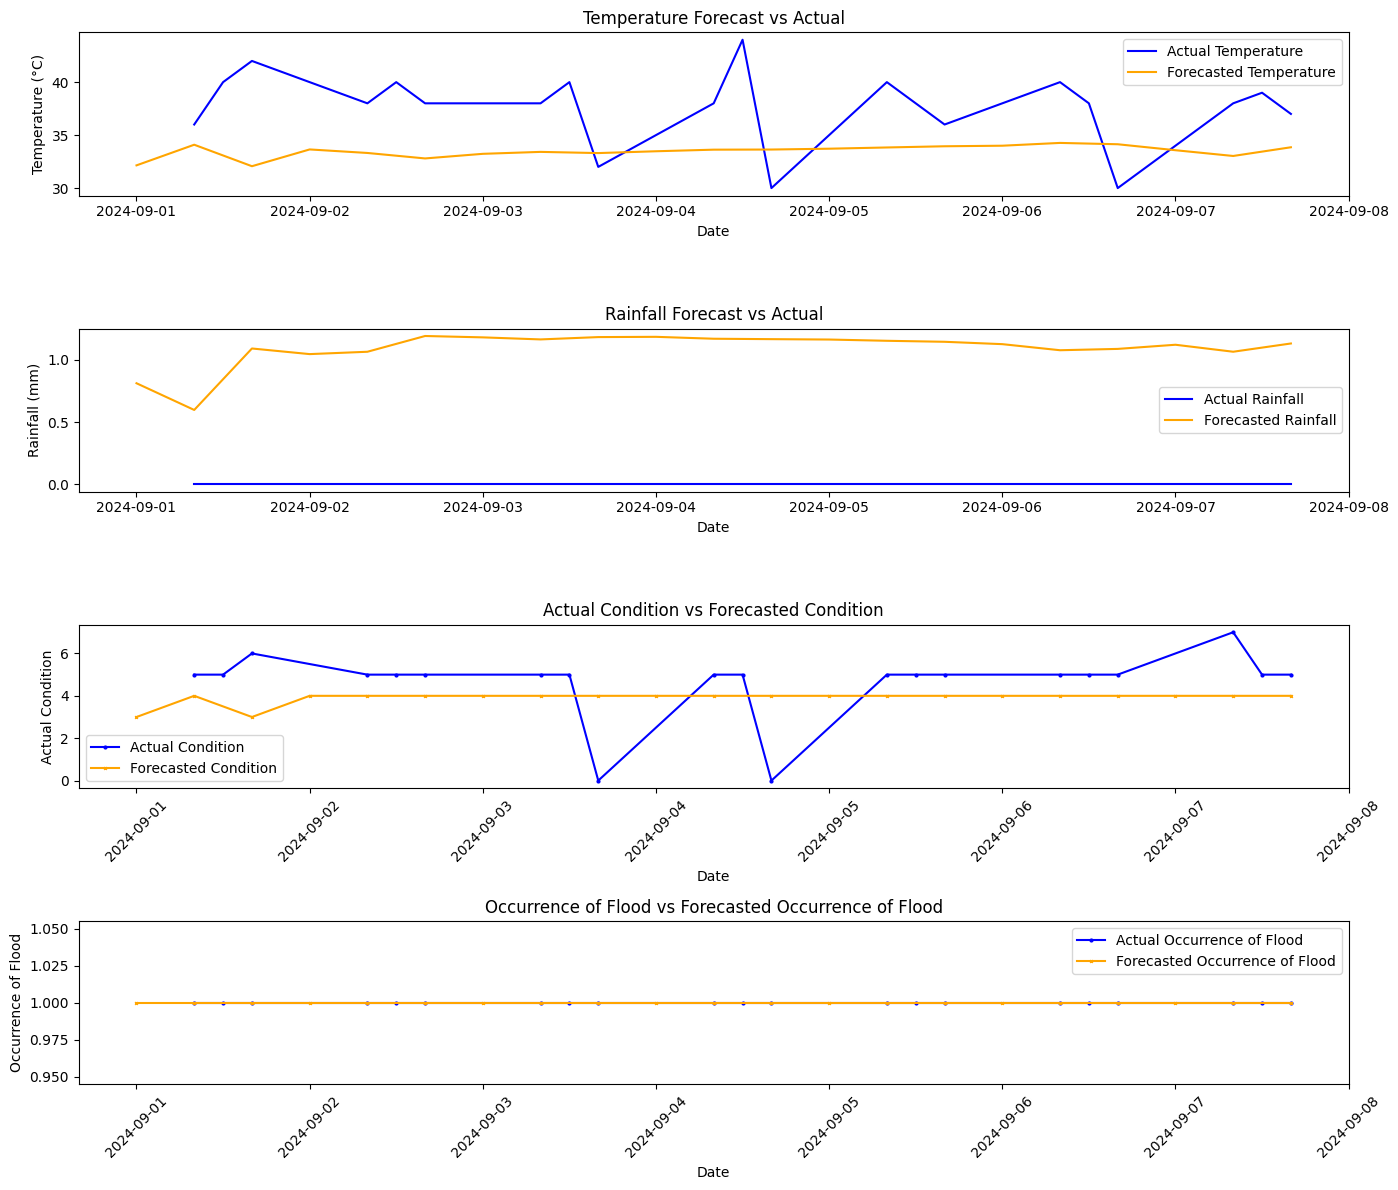

In [12]:
# Load actual data for comparison
actual_data = pd.read_csv('Actual.csv')
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])

# Plotting the actual vs forecasted data
plt.figure(figsize=(14, 12))
print(forecast_df)
# Plot Temperature
plt.subplot(4, 1, 1)
plt.plot(actual_data['DATETIME'], actual_data['TEMPERATURE (°C)'], label='Actual Temperature', color='blue')
plt.plot(forecast_df['DATETIME'], forecast_df['TEMPERATURE (°C)'], label='Forecasted Temperature', color='orange')
plt.title('Temperature Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot Rainfall
plt.subplot(4, 1, 2)
plt.plot(actual_data['DATETIME'], actual_data['RAINFALL (mm)'], label='Actual Rainfall', color='blue')
plt.plot(forecast_df['DATETIME'], forecast_df['RAINFALL (mm)'], label='Forecasted Rainfall', color='orange')
plt.title('Rainfall Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()

# Plot Actual Condition
plt.subplot(4, 1, 3)
plt.plot(actual_data['DATETIME'], actual_data['ACTUAL CONDITION'], label='Actual Condition', color='blue', marker='o', markersize=2)
plt.plot(forecast_df['DATETIME'], forecast_df['ACTUAL CONDITION'], label='Forecasted Condition', color='orange', marker='x', markersize=2)
plt.title('Actual Condition vs Forecasted Condition')
plt.xlabel('Date')
plt.ylabel('Actual Condition')
plt.xticks(rotation=45)
plt.legend()

# Plot Occurrence of Flood
plt.subplot(4, 1, 4)
plt.plot(actual_data['DATETIME'], actual_data['OCCURENCE OF FLOOD'], label='Actual Occurrence of Flood', color='blue', marker='o', markersize=2)
plt.plot(forecast_df['DATETIME'], forecast_df['OCCURENCE OF FLOOD'], label='Forecasted Occurrence of Flood', color='orange', marker='x', markersize=2)
plt.title('Occurrence of Flood vs Forecasted Occurrence of Flood')
plt.xlabel('Date')
plt.ylabel('Occurrence of Flood')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

    TEMPERATURE (°C)  RAINFALL (mm)            DATETIME  ACTUAL CONDITION  \
0          32.144943       0.812180 2024-09-01 00:00:00                 3   
1          34.092873       0.597596 2024-09-01 08:00:00                 4   
2          32.064800       1.091357 2024-09-01 16:00:00                 3   
3          33.647770       1.046218 2024-09-02 00:00:00                 4   
4          33.314819       1.065090 2024-09-02 08:00:00                 4   
5          32.798561       1.191692 2024-09-02 16:00:00                 4   
6          33.233654       1.180702 2024-09-03 00:00:00                 4   
7          33.416580       1.164250 2024-09-03 08:00:00                 4   
8          33.304276       1.182922 2024-09-03 16:00:00                 4   
9          33.475624       1.185029 2024-09-04 00:00:00                 4   
10         33.626217       1.169696 2024-09-04 08:00:00                 4   
11         33.638577       1.166388 2024-09-04 16:00:00                 4   

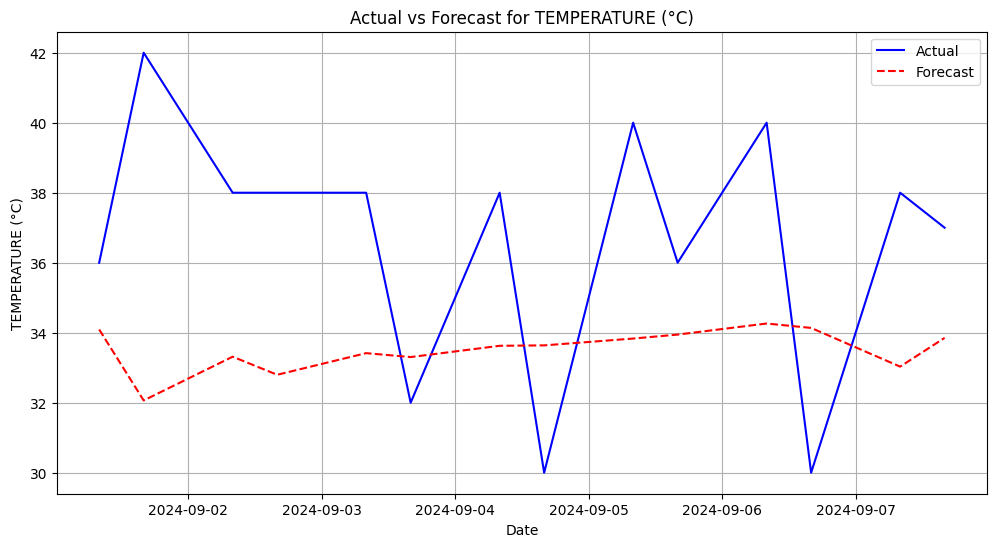

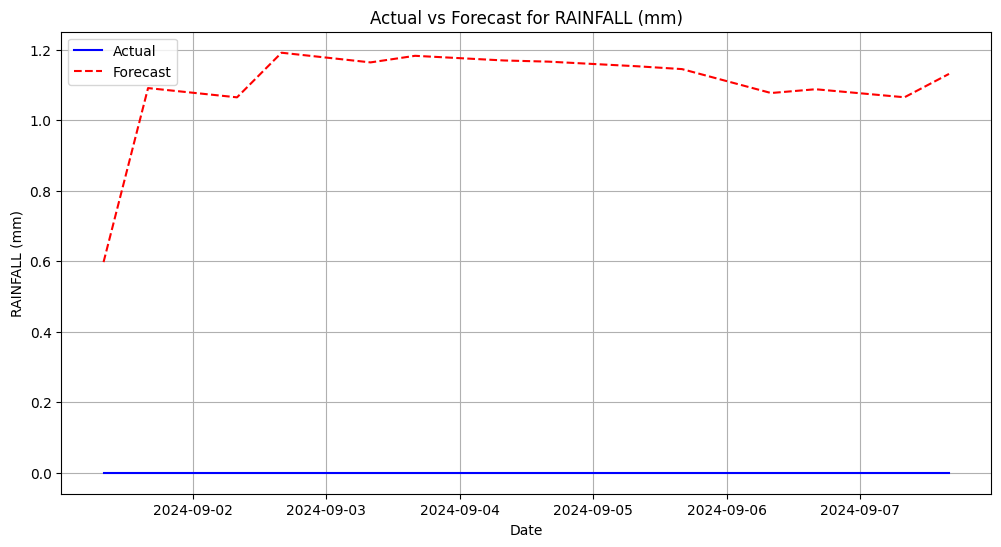

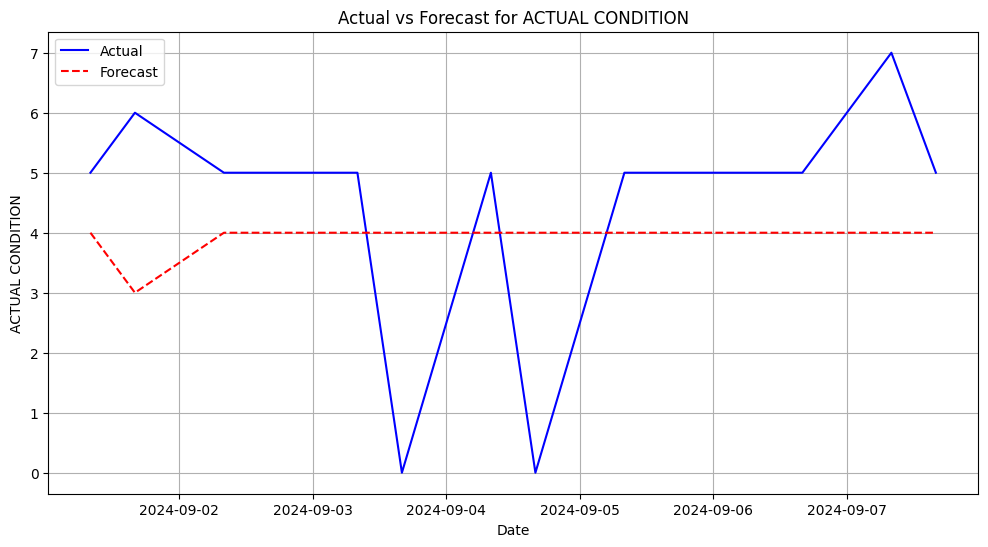

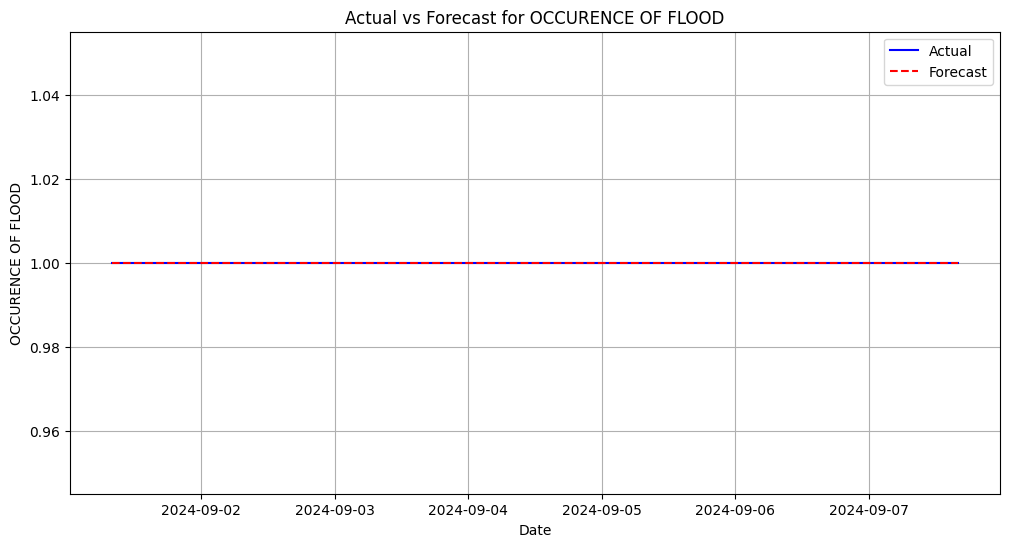

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the actual data from 'Actual.csv'
actual_data = pd.read_csv('Actual.csv')

# Convert 'DATETIME' columns to datetime objects for proper plotting and indexing
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])
forecast_df['DATETIME'] = pd.to_datetime(forecast_df['DATETIME'])
print(forecast_df)

# Set the 'DATETIME' column as the index for both DataFrames
actual_data.set_index('DATETIME', inplace=True)
forecast_df.set_index('DATETIME', inplace=True)

# Ensure that the indices align for comparison
common_index = actual_data.index.intersection(forecast_df.index)
actual_data = actual_data.loc[common_index]
forecast_df = forecast_df.loc[common_index]

# Check if the data is aligned properly
if actual_data.empty or forecast_df.empty:
    print("Error: No common indices found between actual and forecast data.")
else:
    # Calculate performance metrics
    metrics = {}
    for column in actual_data.columns:
        if column in forecast_df.columns:
            y_true = actual_data[column]
            y_pred = forecast_df[column]
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            metrics[column] = {'MAE': mae, 'RMSE': rmse}
            print(f"{column} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # Plot actual vs forecasted values for visual comparison
    for column in actual_data.columns:
        if column in forecast_df.columns:
            plt.figure(figsize=(12, 6))
            plt.plot(actual_data.index, actual_data[column], label='Actual', color='blue')
            plt.plot(forecast_df.index, forecast_df[column], label='Forecast', color='red', linestyle='--')
            plt.title(f'Actual vs Forecast for {column}')
            plt.xlabel('Date')
            plt.ylabel(column)
            plt.legend()
            plt.grid(True)
            plt.show()


Weather Forecasting Report: GRU Model
Introduction
This report evaluates the performance of the weather forecasting model developed using the Gated Recurrent Unit (GRU) architecture. The model was designed to predict four essential weather features: Temperature (°C), Rainfall (mm), Actual Condition, and Occurrence of Flood. The performance of the model is assessed using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) as evaluation metrics.

Model Evaluation Metrics
Feature	Mean Absolute Error (MAE)	Root Mean Squared Error (RMSE)
Temperature (°C)	4.42	4.88
Rainfall (mm)	1.09	1.10
Actual Condition	1.71	2.07
Occurrence of Flood	0.00	0.00
Feature-wise Analysis
Temperature (°C)

MAE: 4.42
On average, the temperature predictions deviate from the actual values by 4.42°C, indicating a noticeable error in the model's performance for this feature.
RMSE: 4.88
The RMSE is higher than the MAE, suggesting that there are significant outliers affecting the predictions. This should be addressed to improve overall accuracy.
Rainfall (mm)

MAE: 1.09
The average error for rainfall predictions is relatively low, demonstrating that the model performs reasonably well in this area.
RMSE: 1.10
The RMSE is close to the MAE, indicating that large errors are not significantly impacting the prediction accuracy for rainfall.
Actual Condition

MAE: 1.71
The average error indicates that the model's predictions for actual weather conditions have a moderate level of inaccuracy.
RMSE: 2.07
The higher RMSE suggests that there are instances of significant misclassifications, indicating a need for further investigation and potential improvements in model training.
Occurrence of Flood

MAE: 0.00
The model effectively predicts flood occurrences without any error, indicating perfect accuracy in this aspect.
RMSE: 0.00
The RMSE confirms that the model is consistently accurate in predicting the occurrence of floods, with no discrepancies between predicted and actual values.

Insights and Recommendations
Model Performance: The GRU model shows strong performance in predicting rainfall and the occurrence of floods, while temperature and actual condition predictions indicate room for improvement.
Data Examination: It is advisable to analyze the dataset further for any potential outliers or imbalances that may impact the temperature and actual condition predictions.
Model Enhancement: Further refinement of the GRU model, including hyperparameter tuning and possible architecture modifications, could enhance its predictive capabilities, especially for features with higher error metrics.
Ongoing Evaluation: Regular monitoring of the model’s performance with new datasets will be essential to maintain accuracy and reliability in forecasts over time.


Conclusion
The GRU model for weather forecasting demonstrates effective results, particularly in forecasting rainfall and flood occurrences. While the overall accuracy is commendable, the identified challenges with temperature and actual condition predictions highlight areas for further exploration and enhancement. Continued efforts to improve the model's performance will be crucial for practical applications in weather forecasting.